x0,fx0: [[0.       ]
 [0.       ]
 [2.3795651]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]] 24.06480760605276
A: [[ 2.         -0.14858774  0.12922984  0.63046635 -0.39176545  0.23708938
  -0.01247868 -0.25223174  0.22816377  0.21144231]
 [-0.14858774  2.          0.02890615 -0.10234805  0.50379541  0.39139194
   0.44351853 -0.15534201  0.60812994 -0.64750151]
 [ 0.12922984  0.02890615  2.         -0.19979175  0.4908787  -0.20225383
   0.12033629 -0.22202374  0.03235937  0.28180017]
 [ 0.63046635 -0.10234805 -0.19979175  2.         -0.16148558  0.22962536
  -0.00711859  0.16901684  0.24340436  0.07209029]
 [-0.39176545  0.50379541  0.4908787  -0.16148558  2.         -0.41410475
  -0.06577692  0.29665929 -0.24080757  0.28807409]
 [ 0.23708938  0.39139194 -0.20225383  0.22962536 -0.41410475  2.
   0.06558149 -0.21169549  0.15695668  0.24691246]
 [-0.01247868  0.44351853  0.12033629 -0.00711859 -0.06577692  0.06558149
   2.         -0.2299889

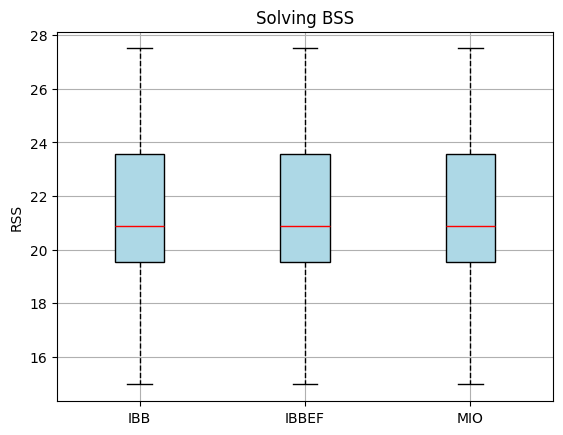

In [ ]:

import numpy as np
from scipy import linalg
import testalg
import matplotlib.pyplot as plt

num_dim=3   # no. of examples of different dimensions
dim_egs=np.array([15,20,25])  # dimension of examples
num_data_pts=np.array([200,200,200])
num_k_values=5    
k_values=np.array([2,4,6,8,10]) 
s0_values=5*np.ones(num_dim,dtype=int) # no. of nonzero values in b0
num_instances=1           # no. of instances to run for each example
alg_flag=np.array([1, 1, 1]) # =1 include in testing, =0 do not include  
num_alg=3
b0_type=1   # to generate the true coefficient vector b0

# initialize the arrays to save the final output
rss=np.zeros( (num_dim*num_k_values,num_alg) )
cpu_time=np.zeros( (num_dim*num_k_values,num_alg) )
num_iter=np.zeros( (num_dim*num_k_values,num_alg) )
stop_flag=-1*np.zeros( (num_dim*num_k_values,num_alg) )
for i in range(num_dim):

    p=dim_egs[i]
    n=num_data_pts[i]
    mu=np.zeros(p)
    sigma=np.eye(p)
    s0=s0_values[i]
    if b0_type==1: # example 1
        b0=np.zeros(p)
        i0=np.ceil(np.linspace(0,p,num=s0,endpoint=False)).astype(int) # get s0 evenly spaced indices, round the next integer if needed
        b0[i0]=1 
    elif b0_type==2: # example 2
        b0=np.zeros(p)
        b0[0:s0]=1 # make first s0 entries 1
    elif b0_type==3: # example 3
        b0=np.zeros(p)   
        i0 = np.random.randint(0,p,s0).astype(int) # pick s0 random indices to make nonzero
        j0 = np.random.randint(1,5,s0) # pick s0 random integers b/w 1 and 5
        b0[i0]=j0

    b0 = np.reshape(b0, (-1,1)) # make it a col array
    
    # run the algorithms and save the output
    for j in range(num_k_values): # for each k value, run the alg
        
        k = k_values[j]
        stop_flag_each_alg, cpu_time_each_alg, rss_each_alg=testalg.main(p,n,k,b0,mu,sigma,num_instances,num_alg,alg_flag)
        rss[j+i*num_k_values,:]=rss_each_alg
        cpu_time[j+i*num_k_values,:]=cpu_time_each_alg
        stop_flag[j+i*num_k_values,:]=stop_flag_each_alg


# save the output in .pkl file
print('rss:',rss)
print('cpu:',cpu_time)
print('stop_flag:',stop_flag)

# create box plots
plt.boxplot(rss,patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(linestyle='--'))
#plt.xlabel('Algorithms')
plt.ylabel('RSS')
plt.title('Solving BSS')
plt.grid(True)
plt.xticks([1, 2, 3], ["IBB","IBBEF", "MIO"])
plt.show() # show the plot    
        